In [1]:
import torch
import numpy as np
import torchvision
import pandas as pd
import random as rd
import torch.nn as nn

from PIL import Image
from pathlib import Path
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    download=True,
    train=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    download=True,
    train=False,
    transform=transform
)

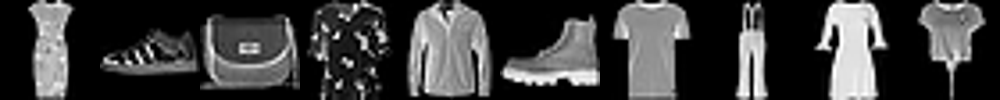

In [5]:
size = 100
final_image = Image.new('L', (size*10, size))

for i, idx in enumerate(rd.sample(range(0, train_dataset.data.shape[0]), 10)):

    image_array = np.array(train_dataset.data[idx, :, :], dtype=np.uint8).reshape((28, 28))
    image = Image.fromarray(image_array).resize((size, size))

    final_image.paste(image, (size*i, 0))

final_image


## Create Model

### encoder

In [6]:
batch_size = 1
num_classes = 10
learning_rate = 0.001
num_epochs = 20

In [42]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

      
    def forward(self, x):
        
        x = x.type(torch.float32)

        out = self.relu1(self.conv_layer1(x))
        out = self.relu2(self.conv_layer2(out))
        out = self.conv_layer3(out)

        _, c, h, w = out.shape
        out = out.view(-1, c, h * w)
        out = out.permute(0, 2, 1)


        return out
    

In [113]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

      
    def forward(self, x):
        
        x = x.type(torch.float32)

        x = x.view(1, 28, 28, 64)
        x = x.permute(0, 3, 1, 2)

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)

        return out

In [117]:
class Quantizer(nn.Module):
    def __init__(self, k: int, d: int, distance: str = "L2"):
        """
        distance : choose among [L2, cos]
        """
        super(Quantizer, self).__init__()
        self.distance = distance
        assert self.distance in ["L2", "cos"]
        
        self.embedding = nn.Embedding(k, d)

    def forward(self, z_e):

        if self.distance == "L2":
            distances = (
                torch.sum(z ** 2, dim=-1, keepdim=True)                         # a²
                + torch.sum(self.embedding.weight.T ** 2, dim=0, keepdim=True)  # b²
                - 2 * torch.matmul(z_e, self.embedding.weight.T)                  # -2ab
            )

        elif self.distance == "cos":

            ## cos(a, b) = a.b / ||a|| ||b||

            a: torch.Tensor = z_e
            b: torch.Tensor = self.embedding.weight

            numerator = a@b.T

            denominator = a.norm(dim=-1, keepdim=True) @ b.norm(dim=-1, keepdim=True).T

            distances = numerator * (1/denominator)
        

        encoded_z = torch.argmin(distances, dim=-1)

        z_q = self.embedding(encoded_z)

        return z_q
        

In [10]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [118]:
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(k=10, d=64, distance="cos")

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [119]:
for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):  

        x = images.to(device)
        labels = labels.to(device)

        # Forward pass
        z_e = encoder(x)

        z_q = quantizer(z_e)
        
        xprime = decoder(z_q)

        break
    break